In [ ]:
import pandas as pd
import requests
import os
import time
import random

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

In [ ]:
HEADERS = {"User-Agent": "Mozilla/5.0"}

# 0. 나스닥100 기업들의 티커
def get_nasdaq100_tickers(yahoo_style: bool = False) -> list[str]:
    
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    html = requests.get(url, headers=HEADERS, timeout=20).text
    tables = pd.read_html(html)

    # 'Ticker' 또는 'Symbol' 컬럼이 포함된 표 찾기
    for t in tables:
        if any(col in t.columns for col in ["Ticker", "Symbol"]):
            df = t
            break
    else:
        raise RuntimeError("위키피디아에서 티커 표를 찾지 못했습니다.")

    col = "Ticker" if "Ticker" in df.columns else "Symbol"
    tickers = df[col].dropna().astype(str).tolist()

    # yahoofinance에서 검색가능한 형태로 형식을 바꿔줌
    if yahoo_style:
        tickers = [t.replace(".", "-") for t in tickers]

    return tickers

nasdaq100 = get_nasdaq100_tickers(yahoo_style=True)

In [ ]:
# 1. 티커에 대한 뉴스 url 요청
def get_href(query, count=20):
    url = f"https://query1.finance.yahoo.com/v1/finance/search?q={query}&newsCount={count}&start=0"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/127.0.0.0 Safari/537.36",
        "Accept": "application/json, text/javascript, */*; q=0.01",
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://finance.yahoo.com/",
        "Connection": "keep-alive",
    }

    response = requests.get(url, headers=headers)
    print(f"[{query}] Status Code: {response.status_code}")

    results = []
    if response.status_code == 200:
        data = response.json()
        for item in data.get("news", []):
            link = item.get("link")
            results.append(link)

    return results[:count]

In [ ]:
# 2. CSV 업데이트 함수

def update_csv(query, csv_path="yahoo_news.csv", filtered_path="yahoo_filtered.csv"):
    new_links = get_href(query)

    # 이전에 크롤링한 data
    if os.path.exists(csv_path):
        df_old = pd.read_csv(csv_path)
        old_pairs = set(zip(df_old["ticker"], df_old["link"]))
    else:
        df_old = pd.DataFrame(columns=["ticker", "link", "headline", "pubdate", "related_tickers", "article"])
        old_pairs=set()
    
    # 추출 대상에서 제외된 url data
    if os.path.exists(filtered_path):
        df_filtered = pd.read_csv(filtered_path)
        filtered_pairs = set(zip(df_filtered["ticker"], df_filtered["link"]))
    else:
        filtered_pairs = set()

    # 이전에 실행하지 않았던 url만 모으기
    unique_links = [
        link for link in new_links
        if (query, link) not in old_pairs and (query, link) not in filtered_pairs
    ]

    # 새로운 데이터프레임 생성 (티커 포함)
    df_new = pd.DataFrame(unique_links, columns=["link"])
    df_new["ticker"] = query

    # 합치기
    df_updated = pd.concat([df_old, df_new], ignore_index=True)

    # 중복 제거(더블 체크)
    df_updated = df_updated.drop_duplicates(subset=["ticker","link"], keep="first")

    # 저장
    df_updated.to_csv(csv_path, index=False, encoding="utf-8-sig")

    print(f"[{query}] 새로운 링크 {len(unique_links)}개 추가됨. 전체 {len(df_updated)}개 저장됨.")
    return df_updated

In [ ]:
# 3. 추출 대상에서 제외된 url을 csv로 저장해두는 함수
def save_filtered(query, link, filtered_path="yahoo_filtered.csv"):
    # 기존 파일 불러오기
    if os.path.exists(filtered_path):
        df_filtered = pd.read_csv(filtered_path)
    else:
        df_filtered = pd.DataFrame(columns=["ticker", "link"])

    # 새로운 행 추가
    new_row = pd.DataFrame([{"ticker": query, "link": link}])
    df_filtered = pd.concat([df_filtered, new_row], ignore_index=True)

    # 중복 제거
    df_filtered = df_filtered.drop_duplicates(subset=["ticker", "link"], keep="first")

    # 저장
    df_filtered.to_csv(filtered_path, index=False, encoding="utf-8-sig")
    print(f"추출 대상에서 제외된 url 저장: {link}")

In [ ]:
# 4. 기사 크롤링 함수
def scrape_articles(df, query, driver, csv_path="yahoo_news.csv"):

    # 재실행 시 index 불일치 해결을 위함
    i = 0
    while i < len(df):
        link = df.iloc[i]["link"]

        # 이미 headline 있으면 skip
        if "headline" in df.columns and pd.notnull(df.iloc[i]["headline"]):
            i += 1
            continue

        driver.get(link)
        time.sleep(2)

        try:
            # 필터링 조건1: PREMIUM News
            head_str = driver.find_element(By.XPATH, '//*[@id="main-content-wrapper"]')
            is_premium = head_str.text.split('\n', 1)[0].strip()
            if is_premium == "PREMIUM":
                print(f"Skip PREMIUM article: {link}")
                save_filtered(query, link)
                df = df.drop(df.index[i]).reset_index(drop=True)
                continue
            # 필터링 조건2: Yahoo Finance Video
            try:
                head_str_2 = driver.find_element(By.CLASS_NAME, 'byline-attr-author.yf-1k5w6kz')
                if 'Yahoo Finance Video' in head_str_2.text:
                    print(f"Skip Yahoo Finance VIDEO article: {link}")
                    save_filtered(query, link)
                    df = df.drop(df.index[i]).reset_index(drop=True)
                    continue
            except NoSuchElementException:
                pass

            # 필터링 조건3: 다양한 출처들(개인적인 견해를 포함한 글)
            try:
                element = driver.find_element(
                    By.CSS_SELECTOR,
                    'div.cover-wrap div.top-header a.subtle-link[aria-label]'
                )
                aria_label_value = element.get_attribute('aria-label')
                blocked_sources = [
                    'Motley Fool', 'Barchart', 'The Wall Street Journal',
                    'Zacks', 'Benzinga', 'Quartz'
                ]
                if any(src in aria_label_value for src in blocked_sources):
                    print(f"Skip SOURCE article ({aria_label_value}): {link}")
                    save_filtered(query, link)
                    df = df.drop(df.index[i]).reset_index(drop=True)
                    continue
            except NoSuchElementException:
                pass

            # 기사 제목
            headline = driver.find_element(By.CLASS_NAME, 'cover-headline.yf-1rjrr1').text
            # 발행일
            pubdate = driver.find_element(By.CLASS_NAME, 'byline-attr-meta-time').text
            # 관련 티커 (없는 경우 존재 -> None)
            try:
                tickers = driver.find_element(By.CLASS_NAME, 'carousel-top').text
            except NoSuchElementException:
                tickers = None
            # 기사 본문
            article = driver.find_element(By.CLASS_NAME, 'bodyItems-wrapper').text

            # 더보기 버튼 존재 시 클릭 -> 추가 본문
            try:
                continue_button = driver.find_element(By.CSS_SELECTOR, "button[aria-label='Story Continues']")
                continue_button.click()
                time.sleep(1)
                # 추가 본문
                add_article = driver.find_element(By.CLASS_NAME, 'read-more-wrapper').text
                # 본문 합치기
                article += "\n" + add_article
            except NoSuchElementException:
                pass

            # df 업데이트
            df.loc[i, "ticker"] = query
            df.loc[i, "headline"] = headline
            df.loc[i, "pubdate"] = pubdate
            df.loc[i, "related_tickers"] = tickers
            df.loc[i, "article"] = article

            # 정상 처리됐으면 i 증가
            i += 1

        except Exception as e:
            print(f"Error on {link}: {e}")
            # 에러 난 행도 삭제 (다시 시도하지 않음)
            df = df.drop(df.index[i]).reset_index(drop=True)
            # i 증가 안 함 → drop했으니 다음 행이 자동으로 i 위치에 옴

    # 저장 후 종료
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"[{query}] 크롤링 완료 후 저장됨.")

In [ ]:
# 5. 결측치 제거 함수
def cleanup_csv(csv_path="yahoo_news.csv"):
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        mask = df[["headline", "pubdate", "article"]].isnull().all(axis=1)
        df = df.drop(df.index[mask]).reset_index(drop=True)
        df.to_csv(csv_path, index=False, encoding="utf-8-sig")
        print(f"Null 행 {mask.sum()}개 삭제 완료")

In [ ]:
# 6. 모든 티커에 대해서 크롤링 실행
if __name__ == "__main__":

    # 실행 전 클린업 (링크만 있고 기사 데이터 없는 행 제거)
    csv_path = "yahoo_news.csv"
    cleanup_csv(csv_path)

    chrome_options = Options()
    chrome_options.add_argument('--headless')
    driver = webdriver.Chrome(options=chrome_options)

    nasdaq100 = get_nasdaq100_tickers(yahoo_style=True)

    try:
        for ticker in nasdaq100:
            df = update_csv(ticker, csv_path=csv_path, filtered_path="yahoo_filtered.csv")
            scrape_articles(df, ticker, driver, csv_path=csv_path)
            time.sleep(random.uniform(3, 6))  # 과부하 방지
    finally:
        driver.quit()
        print("모든 크롤링 완료 후 브라우저 종료")

In [ ]:
df.shape

(array([60., 25.,  5.,  2.,  1.,  0.,  4.,  1.,  2.,  1.]),
 array([  8. ,  32.1,  56.2,  80.3, 104.4, 128.5, 152.6, 176.7, 200.8,
        224.9, 249. ]),
 <BarContainer object of 10 artists>)

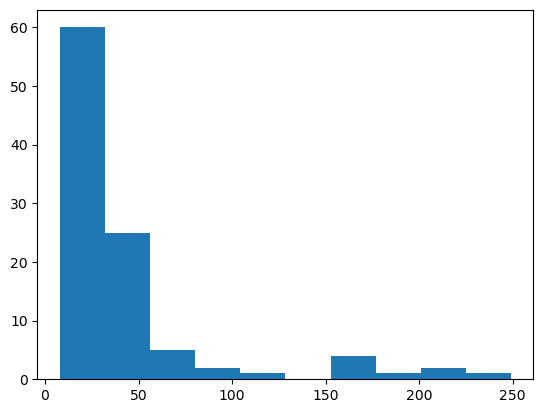

In [12]:
import matplotlib.pyplot as plt
plt.hist(df.groupby('ticker')['ticker'].count())

In [22]:
# 티커별 행 개수 세기
count_by_ticker = df.groupby("ticker")["ticker"].count()

# 이거 바꿔
n = 10
# n개인 티커만 필터
one_article_tickers = count_by_ticker[count_by_ticker <= n].index.tolist()

print(f"기사 {n}개인 티커:", one_article_tickers)

기사 10개인 티커: ['AEP', 'CCEP']


In [24]:
df[df['ticker'] == 'CCEP'].count()

ticker             10
link               10
headline           10
pubdate            10
related_tickers    10
article            10
dtype: int64

In [46]:
# 실험용 크롤링하는 코드. 이상 무
'''
driver = webdriver.Chrome()
for link in df['link']:
    driver.get(link)
    time.sleep(2)  # 페이지 로딩 대기 (상황에 맞게 조정)

    try:
        # PREMIUM인지 확인하기!!
        head_str = driver.find_element(By.XPATH, '//*[@id="main-content-wrapper"]')
        is_premium = head_str.text.split('\n', 1)[0].strip()

        if is_premium == "PREMIUM":
            print(f"Skip PREMIUM article: {link}")
            continue

        # 여기서부터는 PREMIUM이 아닐 때 처리할 로직 넣으면 됨
        print(f"Valid article: {link}")

        # headline
        headline = driver.find_element(By.CLASS_NAME, 'cover-headline.yf-1rjrr1').text
        print("Headline:", headline)

        # pubdate
        pubdate = driver.find_element(By.CLASS_NAME, 'byline-attr-meta-time').text
        print("PubDate:", pubdate)

        # related tickers
        related_tickers = driver.find_element(By.CLASS_NAME, 'carousel-top').text
        print("Related Tickers:", related_tickers)

        # 기본 article
        article = driver.find_element(By.CLASS_NAME, 'atoms-wrapper').text

        # continue button 확인
        try:
            continue_button = driver.find_element(
                By.CLASS_NAME,
                'secondary-btn.fin-size-large.readmore-button.rounded.yf-w054rc'
            )
            continue_button.click()
            time.sleep(1)  # 클릭 후 로딩 대기

            # 추가 article
            add_article = driver.find_element(By.CLASS_NAME, 'read-more-wrapper').text
            article = article + "\n" + add_article

        except NoSuchElementException:
            pass  # continue_button 없으면 무시

        print("Article:", article[-200:], "...")  # 길면 앞부분만 출력

    except Exception as e:
        print(f"Error on {link}: {e}")

    except Exception as e:
        print(f"Error on {link}: {e}")

'''

Valid article: https://finance.yahoo.com/news/jim-cramer-defends-apple-negativity-045503308.html
Headline: Jim Cramer Defends Apple After Negativity
PubDate: Fri, September 12, 2025 at 1:55 PM GMT+9
Related Tickers: StockStory Top Pick
GOOGL
+0.50%
AAPL
+1.43%
Article:  on the best short-term AI stock.
READ NEXT: 30 Stocks That Should Double in 3 Years and 11 Hidden AI Stocks to Buy Right Now.
Disclosure: None. This article is originally published at Insider Monkey. ...
Valid article: https://finance.yahoo.com/news/apple-latest-iphone-security-feature-220046709.html
Headline: Apple’s latest iPhone security feature just made life more difficult for spyware makers
PubDate: Fri, September 12, 2025 at 7:00 AM GMT+9
Related Tickers: StockStory Top Pick
GOOGL
+0.50%
AAPL
+1.43%
Article: ,” said Frielingsdorf. “But there are going to be plenty of bad actors that can still find success and sustain their business.”
“As long as there are buyers there will be sellers,” said Frielingsdorf. ...
Val

In [41]:
# 요소들 찾는 코드!!
'''
# PREMIUM 위치
head_str = driver.find_element(By.XPATH,'//*[@id="main-content-wrapper"]')
is_premium = head_str.text.split('\n', 1)[0].strip() 

# headline
headline = driver.find_element(By.CLASS_NAME, 'cover-headline.yf-1rjrr1')
print(headline.text)

# pubdate
pubdate = driver.find_element(By.CLASS_NAME, 'byline-attr-meta-time')
print(pubdate.text)

# related_tickers
related_tickers = driver.find_element(By.CLASS_NAME, 'carousel-top')
print(related_tickers.text)

# 버튼 클릭 이후 기사와 이전의 기사의 요소가 다름!! 기본 기사 획득 -> continue가 있다면 클릭 후 -> 새로운 기사 획득

# article
article = driver.find_element(By.CLASS_NAME, 'atoms-wrapper')
print(article.text)
# 09/20 변경
article = driver.find_element(By.CLASS_NAME, 'bodyItems-wrapper')
print(article.text)

# continue_button
continue_button = driver.find_element(By.CLASS_NAME,'secondary-btn.fin-size-large.readmore-button.rounded.yf-w054rc')
continue_button.click()
# 09/20 변경
continue_button = driver.find_element(By.CSS_SELECTOR, "button[aria-label='Story Continues']")
continue_button.click()

# add_article
add_article = driver.find_element(By.CLASS_NAME,'read-more-wrapper')
print(add_article.text)
'''

Propel Finance provides an embedded finance offering in partnership with Select to support UK Small & Medium-sized Businesses investing in Apple products
Fri, September 12, 2025 at 4:00 PM GMT+9
AAPL
+1.43%
LONDON, Sept. 12, 2025 /PRNewswire/ -- Propel Finance, the UK's fastest-growing asset finance lender, will work with Apple's channel partners to offer finance solutions to small and medium businesses investing in Apple devices. The programme will be launched with Select, an Apple Premium Partner.
Propel's embedded finance platform will integrate into New York based LiftForward Inc., Apple's selected platform partner for channel subscription and upgrade programmes, to offer market-leading finance through Select to small businesses at the point of sale, both online and in-store. Small businesses purchasing Mac, iPad, iPhone, Apple Watch and accessories will be able to access finance digitally through the purchase journey, with line-level finance options across multiple products in a s

In [37]:
'''
driver = webdriver.Chrome()
url = "https://finance.yahoo.com/quote/AAPL/latest-news/"
driver.get(url)
time.sleep(3)

# 🔽 자동 스크롤 함수
def scroll_to_end(driver, pause_time=2):
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        # 맨 아래까지 스크롤
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pause_time)

        # 새로운 높이 확인
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:  # 더 이상 로드된 게 없으면 종료
            break
        last_height = new_height

# 스크롤 끝까지 내리기
scroll_to_end(driver, pause_time=2)
'''

In [38]:
'''
results = []
idx = 0

while True:
    news_blocks = driver.find_elements(By.CSS_SELECTOR, "li.stream-item.story-item")

    if idx >= len(news_blocks):
        break  # 모든 뉴스 블록 다 돌면 종료

    try:
        block = news_blocks[idx]

        # 출처 텍스트 확인
        source_elem = block.find_element(By.CSS_SELECTOR, "div.publishing")
        source_text = source_elem.text.strip()

        if "Ad" in source_text:
            print(f"[SKIP] {idx+1}번째 뉴스 (광고)")
            idx += 1
            continue

        # 블록 안의 링크 클릭
        link_elem = block.find_element(By.CSS_SELECTOR, "a.subtle-link")
        link = link_elem.get_attribute("href")

        # 바로 기사 페이지로 이동
        driver.get(link)
        time.sleep(2)
        
        # 기사 본문 긁기
        article_elem = driver.find_element(By.CLASS_NAME, 'cover-title')
        article_text = article_elem.text

        results.append({"text": article_text})

        # 뒤로가기
        driver.back()
        time.sleep(2)

    except Exception as e:
        print(f"[ERROR] {idx+1}번째 뉴스에서 에러 발생 → 스킵: {e}")
        try:
            # 혹시 기사 페이지에 멈췄으면 리스트 페이지로 복귀
            driver.back()
            time.sleep(2)
        except:
            pass
        # 그냥 스킵
        idx += 1
        continue

    idx += 1

print("총 수집:", len(results))
'''

총 수집: 6


In [39]:
results

[{'text': "An iPhone Air, new watches, and heart rate-tracking AirPods: What to expect at Apple's Sept. 9 event"},
 {'text': 'Inflation Data, Oracle Earnings, Consumer Sentiment: What to Watch This Week'},
 {'text': 'Chipmaker IQE considers sale as shares slide on lowered earnings guidance'},
 {'text': '1 Momentum Stock with Exciting Potential and 2 We Question'},
 {'text': 'How to keep divorce expenses down as back-to-school break-ups spike'},
 {'text': 'Four ways to invest in gold'}]

In [65]:
driver = webdriver.Chrome()
url = "https://seekingalpha.com/symbol/AAPL/news"
driver.get(url)
time.sleep(2)

In [64]:
# 모든 요소 찾기 (중복 포함)
elements = driver.find_elements(
    By.CSS_SELECTOR, ".text-share-text.visited\\:text-share-text.hover\\:text-share-text.focus\\:text-share-text"
)

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=139.0.7258.155)
Stacktrace:
	GetHandleVerifier [0x0x7ff779c63d85+79397]
	GetHandleVerifier [0x0x7ff779c63de0+79488]
	(No symbol) [0x0x7ff779a0c0fa]
	(No symbol) [0x0x7ff7799e4601]
	(No symbol) [0x0x7ff779a9257e]
	(No symbol) [0x0x7ff779ab2c72]
	(No symbol) [0x0x7ff779a8af73]
	(No symbol) [0x0x7ff779a541b1]
	(No symbol) [0x0x7ff779a54f43]
	GetHandleVerifier [0x0x7ff779f2e1ed+3005069]
	GetHandleVerifier [0x0x7ff779f2831d+2980797]
	GetHandleVerifier [0x0x7ff779f47e0d+3110573]
	GetHandleVerifier [0x0x7ff779c7d6de+184190]
	GetHandleVerifier [0x0x7ff779c8516f+215567]
	GetHandleVerifier [0x0x7ff779c6c974+115220]
	GetHandleVerifier [0x0x7ff779c6cb29+115657]
	GetHandleVerifier [0x0x7ff779c53268+11016]
	BaseThreadInitThunk [0x0x7fff2ad1e8d7+23]
	RtlUserThreadStart [0x0x7fff2cf1c34c+44]


In [61]:
elements.click()

AttributeError: 'list' object has no attribute 'click'

In [60]:
# 한 칸씩 건너뛰기 → 0, 2, 4, 6 ...
for i in range(0, len(elements), 2):
    try:
        elem = elements[i]

        # 링크 주소 가져오기
        link = elem.get_attribute("href")
        print(f"[{i}] 이동: {link}")

        # 새 탭 열기
        driver.execute_script("window.open(arguments[0]);", link)
        driver.switch_to.window(driver.window_handles[-1])

        time.sleep(2)  # 페이지 로딩 대기

        # 기사 본문 긁기 (Yahoo 뉴스 구조에 맞춰 XPath 조정 필요할 수도 있음)
        try:
            article = driver.find_element(By.XPATH, '//*[@id="main-content"]')
            print(article.text[:200], "...\n")  # 앞부분만 출력
        except:
            print("본문 못 찾음")

        # 탭 닫기 → 원래 탭으로 돌아오기
        driver.close()
        driver.switch_to.window(driver.window_handles[0])

    except Exception as e:
        print(f"에러 발생: {e}")
        continue

[0] 이동: None
본문 못 찾음
[2] 이동: None
본문 못 찾음
[4] 이동: None
본문 못 찾음
[6] 이동: None
본문 못 찾음
[8] 이동: None
본문 못 찾음
[10] 이동: None
본문 못 찾음
에러 발생: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=139.0.7258.155)
Stacktrace:
	GetHandleVerifier [0x0x7ff779c63d85+79397]
	GetHandleVerifier [0x0x7ff779c63de0+79488]
	(No symbol) [0x0x7ff779a0c0fa]
	(No symbol) [0x0x7ff7799e4601]
	(No symbol) [0x0x7ff779a9257e]
	(No symbol) [0x0x7ff779a9bf20]
	(No symbol) [0x0x7ff779a8b160]
	(No symbol) [0x0x7ff779a541b1]
	(No symbol) [0x0x7ff779a54f43]
	GetHandleVerifier [0x0x7ff779f2e1ed+3005069]
	GetHandleVerifier [0x0x7ff779f2831d+2980797]
	GetHandleVerifier [0x0x7ff779f47e0d+3110573]
	GetHandleVerifier [0x0x7ff779c7d6de+184190]
	GetHandleVerifier [0x0x7ff779c8516f+215567]
	GetHandleVerifier [0x0x7ff779c6c974+115220]
	GetHandleVerifier [0x0x7ff779c6cb29+115657]
	GetHandleVerifier [0x0x7ff779c53268+11016]
	BaseThreadInitThunk [0x0x7fff2ad1e8d7+23]
	Rtl